In [0]:
import zipfile
with zipfile.ZipFile("../dataset-master.zip", 'r') as zip_ref:
    zip_ref.extractall("")

In [0]:
!pip install pydicom

     |████████████████████████████████| 7.1MB 5.5MB/s 


In [0]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
from sklearn.model_selection import KFold

In [0]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
!python setup.py -q install

In [0]:
# Import Mask RCNN
sys.path.append('Mask_RCNN')  # To find local version of the library


In [0]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN

import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time

from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model

%matplotlib inline

from os import listdir
from xml.etree import ElementTree



In [20]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
     # kangaroo + BG
    NUM_CLASSES = 1+1
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 131
    
    # Learning rate
    LEARNING_RATE=0.006
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=10

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.006
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
os.mkdir("working")

In [0]:
class KangarooDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        
        # Add classes. We have only one class to add.
        self.add_class("dataset", 1, "RBC")
        
        # define data locations for images and annotations
        images_dir = dataset_dir + '/JPEGImages/'
        annotations_dir = dataset_dir + '/Annotations/'
        
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        for filename in listdir(annotations_dir):
            
            # extract image id
            image_id = filename.split('.')[-2].split('_')[-1]
            
        
            
            # skip all images after 150 if we are building the train set
            if is_train and int(image_id) < 50:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and int(image_id) >= 50:
                continue
            
            # setting image file
            img_path = images_dir + filename.split('.')[-2] + '.jpg'
            
            # setting annotations file
            ann_path = annotations_dir + filename.split('.')[-2] + '.xml'
            
            # adding images and annotations to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    # load the masks for an image
    """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        
        # define anntation  file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
       
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('RBC'))
        return masks, asarray(class_ids, dtype='int32')

    # load an image reference
    #Return the path of the image."""
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        path=info['path']
        image = plt.imread(path)
        return image

In [32]:
# prepare train set
train_set = KangarooDataset()
train_set.load_dataset('dataset-master', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = KangarooDataset()
test_set.load_dataset('dataset-master', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 296
Test: 47


In [0]:
image_id = random.choice(train_set.image_ids)

{'id': '00392', 'source': 'dataset', 'path': 'dataset-master/JPEGImages/BloodImage_00392.jpg', 'annotation': 'dataset-master/Annotations/BloodImage_00392.xml'}
(480, 640, 3)


(-0.5, 639.5, 479.5, -0.5)

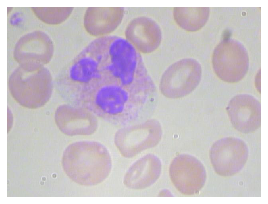

In [24]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(train_set.image_ids)
    image_fp = train_set.image_reference(image_id)
    image = train_set.load_image(image_id)
    mask, class_ids = train_set.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')



dataset-master/JPEGImages/BloodImage_00392.jpg
[1 1 1 1 1 1 1 1 1 1 1 1 1 1]


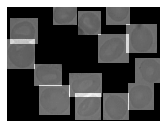

In [25]:
plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

In [26]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


In [33]:
# initialize the Mask R-CNN model for inference 
print("Loading Mask R-CNN model...")
model = modellib.MaskRCNN(mode="training", config=config, model_dir='working/')
#n load the weights for COCO
model.load_weights('mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])


Loading Mask R-CNN model...


In [34]:
# train weights (output layers or 'heads')
## train heads with higher lr to speedup the learning
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')

history = model.keras_model.history.history


Starting at epoch 0. LR=0.006

Checkpoint Path: working/pneumonia20191215T2224/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 1/5
131/131 [==============================] - 150s 1s/step - loss: 1.4644 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 0.3050 - mrcnn_class_loss: 0.3995 - mrcnn_bbox_loss: 0.3557 - mrcnn_mask_loss: 0.3546 - val_loss: 1.4423 - val_rpn_class_loss: 0.0733 - val_rpn_bbox_loss: 0.3076 - val_mrcnn_class_loss: 0.4674 - val_mrcnn_bbox_loss: 0.2942 - val_mrcnn_mask_loss: 0.2998
Epoch 2/5
131/131 [==============================] - 50s 383ms/step - loss: 1.0506 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.2706 - mrcnn_class_loss: 0.3007 - mrcnn_bbox_loss: 0.1953 - mrcnn_mask_loss: 0.2599 - val_loss: 1.1774 - val_rpn_class_loss: 0.0380 - val_rpn_bbox_loss: 0.2267 - val_mrcnn_class_loss: 0.3724 - val_mrcnn_bbox_loss: 0.2380 - val_mrcnn_mask_loss: 0.3023
Epoch 3/5
131/131 [==============================] - 78s 594ms/step - loss: 0.9462 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.2328 - mrcnn_class_loss: 0.2954 - mrcnn_bbox_loss: 0.1587 - mrcnn_mask_loss: 0.2366 - val_loss: 1.1409 - val_rpn_class_

In [0]:

model_path = 'mask_rcnn_'  + '.' + str(time.time()) + '.h5'
model.keras_model.save_weights(model_path)

(480, 640, 3)
[0 1]
(480, 640, 10)
[1 1 1 1 1 1 1 1 1 1]


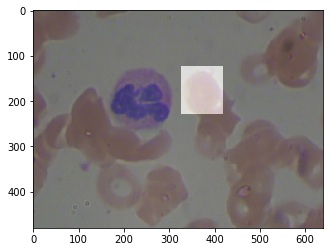

In [36]:
# load an image
image_id = 20
image = test_set.load_image(image_id)
print(image.shape)
print(test_set.class_ids)
# load image mask
mask, class_ids = test_set.load_mask(image_id)

print(mask.shape)
print(class_ids)
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.4)

pyplot.show()

In [0]:
def get_ax(rows=1, cols=1, size=16):
    _, ax = pyplot.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [0]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

#Loading the model in the inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='working/')

# loading the trained weights o the custom dataset
model.load_weights(model_path, by_name=True)
path='dataset-master/JPEGImages/BloodImage_00205.jpg'
img = load_img(path)
img = img_to_array(img)

# detecting objects in the image
result= model.detect([img])

{'id': '00002', 'source': 'dataset', 'path': 'dataset-master/JPEGImages/BloodImage_00002.jpg', 'annotation': 'dataset-master/Annotations/BloodImage_00002.xml'}
image ID: dataset.00002 (10) dataset-master/JPEGImages/BloodImage_00002.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  251.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  135.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


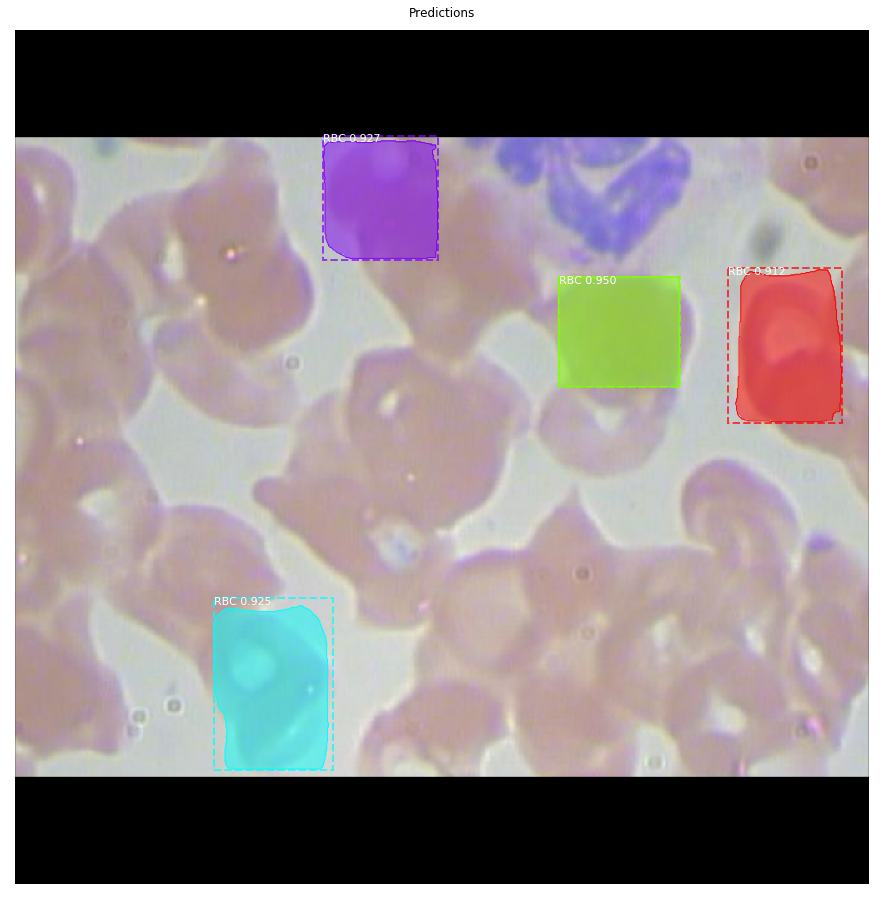

In [52]:
#image_id = random.choice(test_set.image_ids)

image_id = 10
image, image_meta, gt_class_id, gt_bbox, gt_mask =   modellib.load_image_gt(test_set, config, image_id, use_mini_mask=False)
info = test_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       test_set.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'],
                            title="Predictions")